# Work in progress (WIP)

# 4. Deutsch's algorithm

In this lesson you will learn:
- What is a query algorithm?
- Deutsch's algorithm, which provides a clear quantum advantage on recognizing parity of a function.
- Deutsch-Josza algorithm, which generalizes Deutsch's algorithm more than 2 qubits.
- BONUS: Bernstein-Vazirani algorithm

In [1]:
# Specific install for Kaggle Notebooks environment
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

# Kaleido is used to convert Plotly to static png
!pip install -Uqq kaleido
!pip install -Uqq skq

In [2]:
from skq.gates.qubit import H, I, Measure, DeutschJozsaOracle
from skq.circuits import Concat, Circuit

# Fix Plotly rendering in Jupyter forks.
# If you are running this notebook locally you can comment this out.
# This allows you to play with interactive Plotly plots.
import plotly.io as pio
pio.renderers.default = 'png'

# Work in progress (WIP)

- One of the simplest algorithms exhibiting quantum advantage.

- Solves the parity problem in one pass, as opposed to classical algorithms that require at least two passes. The outcome is either constant or balanced.
- One of the query algorithms along with **Deutsch-Josza**, **Grover** and **Shor** algorithms.
- Phase kickback.


$$ U_f \vert x \rangle \vert y \rangle = \vert x \rangle \vert y \oplus f(x) \rangle $$

- $0$ if $f$ is constant. $1$ if $f$ is balanced.

- Balanced means $f(0) \neq f(1)$. Constant means $f(0) = f(1)$.

- No entanglement required.

## Deutsch

The only difference between the Deutsch and Deutsch-Josza algorithm is that Deutsch's algorithm is for 2 qubits, while Deutsch-Josza generalizes the algorithm to $n$ qubits. Therefore we will right away start using the `DeutschJozsaOracle` object. `DeutschJozsaOracle(f, n_bits=2)` is the same as Deutsch's algorithm.


The oracle will be different depending on whether the function is constant or balanced.

In [3]:
def create_deutsch_balanced():
    def balanced_function(x):
        """f(0)=0, f(1)=0, f(2)=1, f(3)=1"""
        return 1 if x >= 2 else 0

    return Circuit([
        Concat([H(), H()]),
        DeutschJozsaOracle(balanced_function, n_bits=2),
        Concat([H(), I()]),
        Measure()
    ])

def create_deutsch_constant():
    def constant_function(x):
        """Always 0: f(0)=0, f(1)=0, f(2)=0, f(3)=0"""
        return 0
    
    return Circuit([
        Concat([H(), H()]),
        DeutschJozsaOracle(constant_function, n_bits=2),
        Concat([H(), I()]),
        Measure()
    ])

In [4]:
balanced_circuit = create_deutsch_balanced()
balanced_circuit([1,0,0,0]).round(3)

array([0. , 0. , 0.5, 0.5])

For balanced functions the probabilities are concentrated in $|10⟩$ and $|11⟩$. The first qubit is always 1, so the function is balanced.

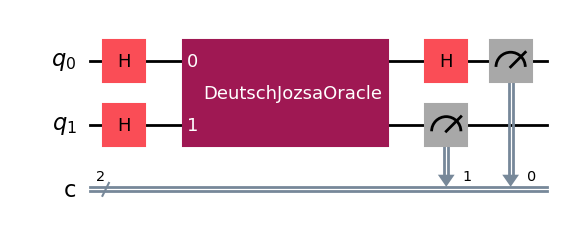

In [5]:
balanced_circuit.draw(output='mpl')

In [6]:
balanced_circuit[1]

DeutschJozsaOracle([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
                    [ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
                    [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j],
                    [ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j]])

In [7]:
constant_circuit = create_deutsch_constant()
constant_circuit([1,0,0,0]).round(3)

array([0.5, 0.5, 0. , 0. ])

For constant functions the probabilities are concentrated in $|00⟩$ and $|01⟩$. The first qubit is always 0, so the function is constant.

In [8]:
constant_circuit[1]

DeutschJozsaOracle([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
                    [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
                    [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
                    [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])

# Work In Progress (WIP)

## Deutsch-Josza

- Very similar to Deutsch's algorithm.
- Extends Deutsch's algorithm to $n \geq 1$ bits.

- $U_f$ has a so-called **promise**. This means that we have to make sure that the function $f$ is either constant or balanced, else the algorithm will not work and will give unpredictable results. 

- Balanced function: $f(x_1, \ldots, x_n) = 1$ for exactly $2^{n-1}$ inputs and $f(x_1, \ldots, x_n) = 0$ for the remaining $2^{n-1}$ inputs.
- Constant function: $f(x_1, \ldots, x_n) = 0$ for all inputs or $f(x_1, \ldots, x_n) = 1$ for all inputs.

- Deterministic classical algorithm requires $2^{n-1} + 1$ queries to determine if the function is constant or balanced. 

- A probabilistic classical algorithm requires a few queries.

1. Choose $k$ input strings $x_1, \ldots, x_k$ at random.
2. If $f(x_i) = 1$ for all $i = 1, \ldots, k$, then output constant, else balanced. If $f$ is constant algorithm is 100% correct. if $f$ is balanced, the algorithm is correct with probability $1 - 2^{-k+1}$.

- Deutsch-Josza algorithm requires only $1$ query.

- The same Deutsch-Josza algorithm can also solve the **Bernstein-Vazirani** problem. A recursive version of Bernstein-Vazirani was one of the first algorithms that gain a superpolynomial advantage over classical algorithms.

# TODO Show both Deutsch-Josza and probabilistic classical algorithm.



# BONUS: Bernstein-Vazirani

- In essence the same circuit as Deutsch-Josza.

- Difference: Oracle encodes bitstring $s$, instead of a function $f$.



# Work In Progress (WIP)